# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### CRISP:DM - Phase 1 : Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary.

### Problem Statement:
The primary business objective of this project is to predict the price of a used car by analyzing a large dataset of past sales. The goal is to identify and estimate the impact of various features (such as mileage, year, make/model, and condition) on the final used-car price, determining which factors tend to increase or reduce it.

### CRISP:DM - Phase 2 : Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")

In [54]:
# Data Loading
df = pd.read_csv("data/vehicles.csv")

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [56]:
df.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


#### Data Understanding

**Goal:** Inspect dataset (vehicle.csv) shape, columns, distributions, NaN and identify cleaning needs.
**Steps followed:**
1. Loaded /mnt/data/vehicles.csv.
2. Showed head(), .info() and basic describe() for price.
3. Located price as the target column and counted missing values.

**Observation**

1. Dataset contains  rows × columns: 426,880 × 18.
2. price found as target (non-null for all rows).
3. Numeric columns detected: id, price, year, odometer.
4. Many categorical columns present: region, manufacturer, model, condition, cylinders, fuel, transmission, VIN, drive, size, type, paint_color, state, etc.
5. After dropping rows with missing price the dataset remained 426,880 rows.

**Next steps & Plan of action**
1. For initial model estimation, the following features are considered for dropping due to potential lack of sufficient data or insignificant influence on the target variable ("price"):
2. Region: Dropped due to having no significant influence on "price."
3. Model: Dropped.
4. Highly Sparse/Irrelevant Features: "Cylinders," "Title_status," "transmission," "VIN," "drive," and "size" can also be dropped for the preliminary model.
5. Potentially Insufficient Data: "condition," "paint_color," and "lat" are also flagged as having insufficient data, similar to some features above, and may be selectively dropped.
6. Further analysis on these dropped and sparse features will be considered after an initial, preliminary model has been successfully fitted.


### CRISP:DM - Phase 3 : Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`.

### Goal of Data Preparation Phase:

1. Cleaning data
2. Handling missing values
3. Encoding variables
4. Scaling features
5. Selecting relevant attributes
6. Feature engineering

In [57]:
from sklearn.impute import SimpleImputer

#Remove cars with condition:salvage
df_clean = df[(df['condition'] != 'salvage') | (df['condition'].isna())]

# Remove categorical columns
df_clean = df.select_dtypes(include=['int64', 'float64'])
df_clean = df_clean.dropna()
df_clean = (
    df.drop(columns=['id', 'VIN', 'size', 'url', 'image_url', 'lat', 'long', 'state',
                     'drive', 'title_status', 'transmission', 'region'], errors='ignore')
      .select_dtypes(include=['int64', 'float64'])
      .dropna())

df_clean = df_clean.dropna(subset=['price'])
df_clean = df_clean[df_clean['price'] > 0]         #Drop price with 0, NaN
df_clean = df_clean.dropna(subset=['year'])
df_clean = df_clean[df_clean['year'] > 1980]       #Drop year before 1980
df_clean = df_clean.dropna(subset=['odometer'])
df_clean = df_clean[df_clean['odometer'] > 0]     #Drop odometer with 0, NaN

df_clean

,price,year,odometer
27,33590,2014.0,57923.0
28,22590,2010.0,71229.0
29,39590,2020.0,19160.0
30,30990,2017.0,41124.0
31,15000,2013.0,128000.0
...,...,...,...
426875,23590,2019.0,32226.0
426876,30590,2020.0,12029.0
426877,34990,2020.0,4174.0
426878,28990,2018.0,30112.0


In [58]:
# Feature Engineering:
# Adding a column for Car_Age
from datetime import datetime
current_year = datetime.now().year
if 'year' in df_clean.columns:
    df_clean['car_age'] = current_year - df_clean['year']

# Adding a column for Mileage per year
if 'odometer' in df_clean.columns and 'car_age' in df_clean.columns:
    df_clean['mileage_per_year'] = df_clean['odometer'] / (df_clean['car_age'] + 1)


In [59]:
# Removing outliers, Price (between 500 to 100000, odometer reading 0 to 300000)
df_clean = df_clean[(df_clean['price'] > 500) & (df_clean['price'] < 100000)]
df_clean = df_clean[(df_clean['odometer'] > 0) & (df_clean['odometer'] < 300000)]

Numeric columns: Index(['price', 'year', 'odometer', 'car_age', 'mileage_per_year'], dtype='object')
Top 5 numeric columns by variance: Index(['odometer', 'price', 'mileage_per_year', 'year', 'car_age'], dtype='object')
Explained variance ratio: [0.62860263 0.25579223]
Total variance explained by 2 components: 0.8843948646416784


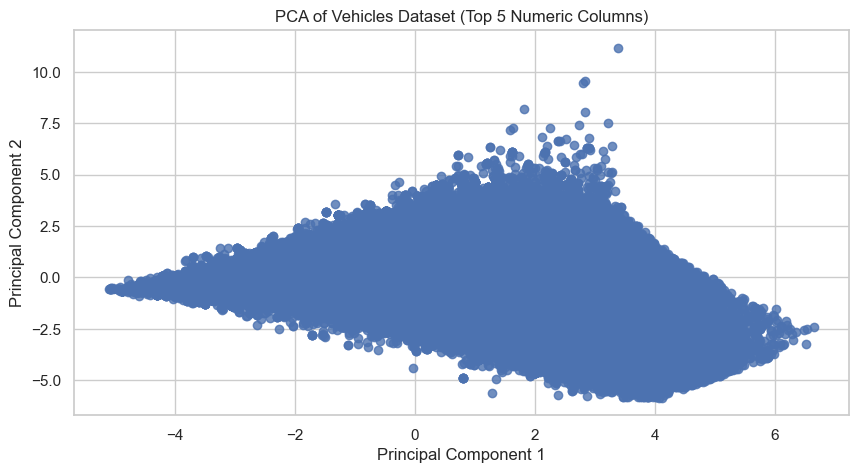

<Figure size 640x480 with 0 Axes>

In [63]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

numeric_cols = df_clean.select_dtypes(include=['int64', 'float64', 'int32']).columns
print("Numeric columns:", numeric_cols)
df_numeric = df_clean[numeric_cols].dropna()
top_cols = df_numeric.var().sort_values(ascending=False).head(5).index
df_numeric = df_numeric[top_cols]
print("Top 5 numeric columns by variance:", top_cols)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_scaled)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total variance explained by 2 components:", sum(pca.explained_variance_ratio_))

# Visualization
plt.figure(figsize=(10,5))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.8)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Vehicles Dataset (Top 5 Numeric Columns)')
plt.savefig('PCA of vehicles.png')
plt.show()

plt.savefig("images/PCA of vehicles.png")



#### Scatterplot of Price and Odometer

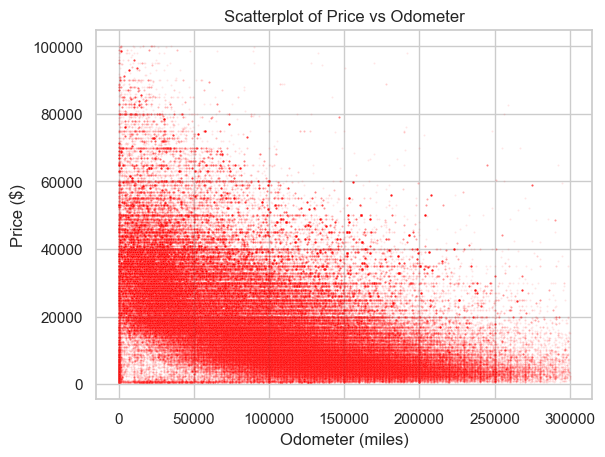

In [66]:
# Plot of Price vs Odometer
# plt.figure(figsize=(15, 10))
sns.scatterplot(df_clean, x='odometer', y='price', alpha=0.1, s=2, color='red' )
plt.title('Scatterplot of Price vs Odometer')
plt.xlabel('Odometer (miles)')
plt.ylabel('Price ($)')
plt.ticklabel_format(style='plain', axis='both')
plt.grid(True)
plt.savefig("images/Scatterplot-price vs odometer.png")
plt.show()

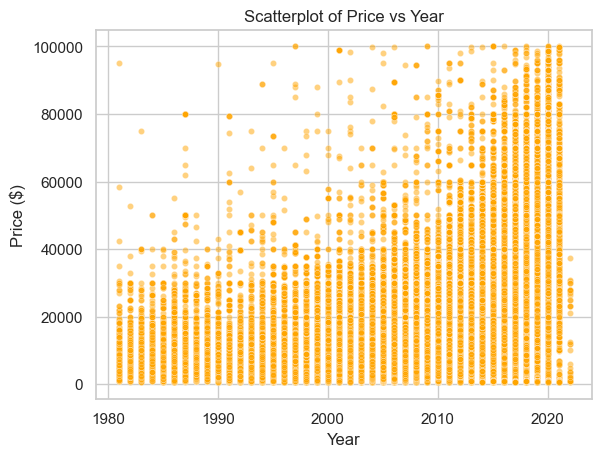

In [69]:
# Price vs Year
sns.scatterplot(df_clean, x='year', y='price', alpha=0.5, s=20, color='orange' )
plt.title('Scatterplot of Price vs Year')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.ticklabel_format(style='plain', axis='both')
plt.grid(True)
plt.savefig("images/Scatterplot-price vs year.png")
plt.show()

#### Summary of Data Understanding Phase:
1. Columns with Int and Float will be used for all estimations.
2. Non numeric features will be used to estimate other factors inpacting the car price.

### CRISP:DM - Phase 4 : Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

#### K-Means Clustering

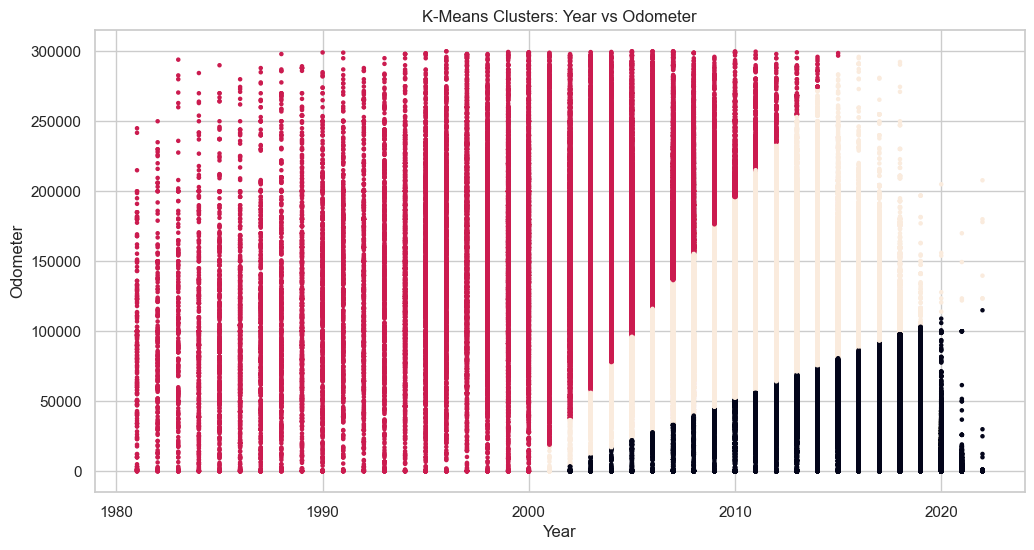

In [72]:
X = df_clean[['year', 'odometer']].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
df.loc[X.index, 'cluster'] = clusters

plt.figure(figsize=(12,6))
plt.scatter(X['year'], X['odometer'], c=clusters, s=5)
plt.xlabel('Year')
plt.ylabel('Odometer')
plt.title('K-Means Clusters: Year vs Odometer')
plt.savefig("images/K-Means Clusters Year vs Odometer.png")
plt.show()

In [73]:
import sklearn.cluster as cluster
# df_clean_new = df_clean.head(100000)
x = df_clean[['year', 'odometer']].dropna()
kmeans = cluster.KMeans(n_clusters=5, init='random')
kmeans.fit(x)
kmeans.labels_

array([1, 1, 2, ..., 2, 2, 2], shape=(368192,), dtype=int32)

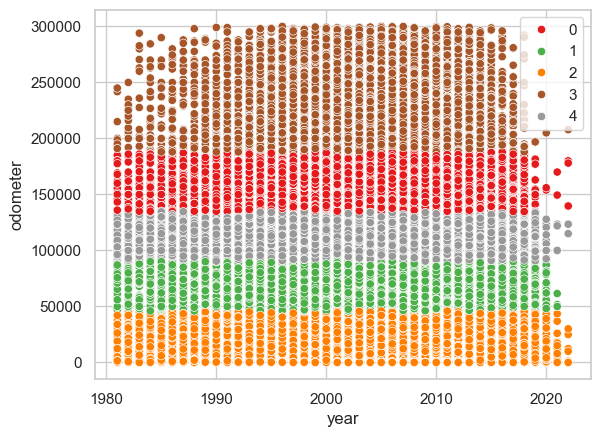

In [75]:
def myscatter(df_clean_new,assignment):
    sns.scatterplot(data=df_clean_new, x='year', y='odometer', hue= assignment, palette =sns.color_palette('Set1', as_cmap=True))
myscatter(x, kmeans.labels_)
plt.savefig("images/K-Means Clusters Year vs Odometer.png")

### DBSCAN
1. Purpose: Identify clusters removing outliers which can indirectly impact the price of the car.
2. Goal: Use on specific features to identify if they impact the car price or not.

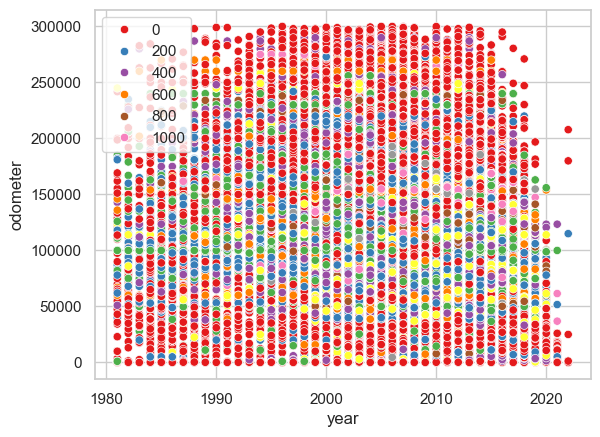

In [76]:
df_clean_new = df_clean.head(200000).dropna(subset=['year', 'odometer'])
x = df_clean_new[['year', 'odometer']].dropna()
dbscan = cluster.DBSCAN(eps=20, min_samples=25).fit(x)
dbscan.labels_
myscatter(df_clean_new, dbscan.labels_)
plt.savefig("images/DBSCAN Clusters Year vs Odometer.png")

#### K-Means ++

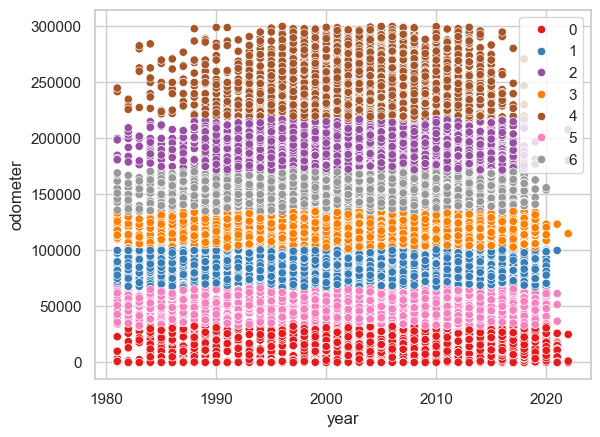

In [77]:
kmeanspp = cluster.KMeans(n_clusters=7, init='k-means++').fit(x)
myscatter(x, kmeanspp.labels_)
plt.savefig("images/K-Means Clusters Year vs Odometer-2.png")

In [78]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

X = df_clean[['year', 'price',]].dropna()
db = DBSCAN(eps=0.5, min_samples=10).fit(X)
X["cluster"] = db.labels_

# Filtering outliers (cluster == -1)
df_no_outliers = X[X["cluster"] != -1]

# training the regression models without outliers
features = ["year"]
X_reg = df_no_outliers[features]
y_reg = df_no_outliers["price"]
X_train, X_test, y_train, y_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)
model = LinearRegression()
model.fit(X_train, y_train)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [79]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score

df_model = df.dropna()
X = df_model[['year', 'odometer', 'manufacturer', 'fuel']]
y = df_model['price']
numerical_features = ['year', 'odometer']
categorical_features = ['manufacturer', 'fuel']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

linear_model = Pipeline([('preprocessor', preprocessor), ('regressor', LinearRegression())])
linear_model.fit(X_train, y_train)



,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [80]:
# LASSO and Ridge Regression

ridge_model = Pipeline([('preprocessor', preprocessor), ('regressor', Ridge(alpha=10.0))])
ridge_model.fit(X_train, y_train)

lasso_model = Pipeline([('preprocessor', preprocessor), ('regressor', Lasso(alpha=0.1, max_iter=10000))])
lasso_model.fit(X_train, y_train)


def evaluate_model(name, model, X_test, y_test):
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    print(f"\n--- {name} ---")
    print(f"MAE: ${mae:,.2f}")
    print(f"R^2: {r2:.4f}")
    return preds

pred_linear = evaluate_model("Linear Regression", linear_model, X_test, y_test)
pred_ridge = evaluate_model("Ridge Regression", ridge_model, X_test, y_test)
pred_lasso = evaluate_model("Lasso Regression", lasso_model, X_test, y_test)

feature_names = (linear_model.named_steps['preprocessor']
                 .transformers_[1][1]
                 .get_feature_names_out(categorical_features))
all_features = np.concatenate([numerical_features, feature_names])

coef_linear = linear_model.named_steps['regressor'].coef_
coef_ridge = ridge_model.named_steps['regressor'].coef_
coef_lasso = lasso_model.named_steps['regressor'].coef_

coef_df = pd.DataFrame({
    'Feature': all_features,
    'Linear_Coef': coef_linear,
    'Ridge_Coef': coef_ridge,
    'Lasso_Coef': coef_lasso
})

zeroed_features = coef_df[coef_df['Lasso_Coef'] == 0]
print(f"\nTotal Features: {len(coef_df)}")
print(f"Features eliminated by Lasso (set to 0): {len(zeroed_features)}")

print("\n ==> Compare the Coefficient  (Top 5 largest Linear Coefs)")
print(coef_df.reindex(coef_df.Linear_Coef.abs().sort_values(ascending=False).index).head(5).to_string(index=False))


--- Linear Regression ---
MAE: $5,835.80
R^2: 0.6082

--- Ridge Regression ---
MAE: $5,851.10
R^2: 0.6026

--- Lasso Regression ---
MAE: $5,835.14
R^2: 0.6084

Total Features: 48
Features eliminated by Lasso (set to 0): 3

 ==> Compare the Coefficient  (Top 5 largest Linear Coefs)
                  Feature  Linear_Coef   Ridge_Coef   Lasso_Coef
     manufacturer_ferrari 72553.680406 25177.896268 76366.961426
manufacturer_aston-martin 43529.440494  4238.675314 45349.885458
       manufacturer_tesla 32120.766826 16902.981317 36123.042359
      manufacturer_datsun 19154.421203  2009.831219 20970.901895
              fuel_diesel 17271.219951 15877.799529 22386.359999


In [81]:
top_mfg = df['manufacturer'].value_counts().head(10).index

In [82]:
df_model = df[df['manufacturer'].isin(top_mfg)].copy()

In [83]:
# Polynomial feature
pfeatures = PolynomialFeatures()
quad_features = pfeatures.fit_transform(df_clean[['odometer']])
poly_features_df = pd.DataFrame(quad_features, columns=pfeatures.get_feature_names_out()).iloc[:, 1:]

print(poly_features_df.shape)
poly_features_df.head()

(368192, 2)


,odometer,odometer^2
0,57923.0,3.355074e+09
1,71229.0,5.073570e+09
2,19160.0,3.671056e+08
3,41124.0,1.691183e+09
4,128000.0,1.638400e+10


In [84]:
# Defining, Computing and optimizing loss functions
thetas = np.linspace(-1, 1, 100)
mses = []
# price = 0.8 * odo_new
price = 0.8 * df_clean['odometer']
mse = mean_squared_error(df_clean['price'], 0.8*df_clean['odometer'])

theta_min = None
min_mse = None

for theta in thetas:
    mse = mean_squared_error(df_clean['price'], theta*df_clean['odometer'])
    mses.append(mse)
    if min_mse == None:
        theta_min = theta
        min_mse = mse
    elif min_mse > mse:
        min_mse = mse
        theta_min = theta

print(type(theta_min))
print(min_mse)
print(theta_min)


<class 'numpy.float64'>
436734503.71544695
0.11111111111111116


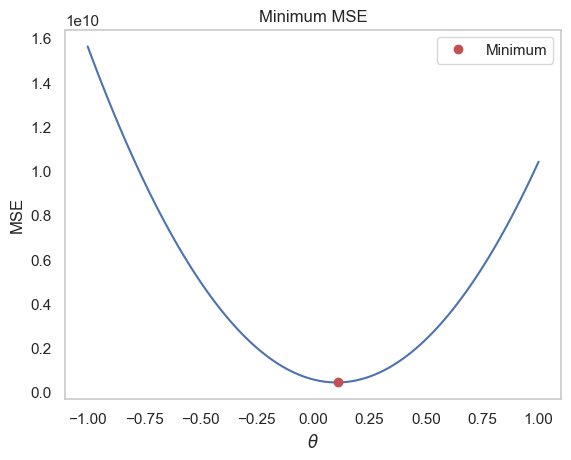

In [86]:
plt.plot(thetas, mses)
plt.plot(thetas[np.argmin(mses)], min(mses), 'ro', label = 'Minimum')
plt.legend()
plt.title('Minimum MSE')
plt.xlabel(r'$\theta$')
plt.ylabel('MSE')
plt.grid()
plt.savefig("images/MSE.png")


In [89]:
# Creating Pipeline, fitting, examine Coeff

pipe = Pipeline([('quad_features', PolynomialFeatures(degree = 2)), ('quad_model', LinearRegression())])
X = df_clean[['odometer']]
y = df_clean['price']
pipe.fit(X, y)
quad_pipe_mse = float(mean_squared_error(y, pipe.predict(X)))
quad_reg = pipe.named_steps['quad_model']
coefs = quad_reg.coef_

print(type(quad_pipe_mse))
print(quad_pipe_mse)
print(type(quad_reg))
print(coefs)

<class 'float'>
136150562.59086844
<class 'sklearn.linear_model._base.LinearRegression'>
[ 0.00000000e+00 -2.45145332e-01  5.47214511e-07]


In [90]:
# Pipeline No bias, MSE, Building a cubic model with Pipeline
pipe_no_bias = Pipeline([('quad_features', PolynomialFeatures(degree = 2, include_bias=False)), ('quad_model', LinearRegression())])
pipe_no_bias.fit(X, y)
no_bias_mse = float(mean_squared_error(y, pipe_no_bias.predict(X)))
print(type(pipe_no_bias))
print(no_bias_mse)

cubic_pipe = Pipeline([('quad_features', PolynomialFeatures(degree = 3, include_bias=False)), ('quad_model', LinearRegression())])
cubic_pipe.fit(X, y)
cubic_mse = float(mean_squared_error(y, cubic_pipe.predict(X)))
print(type(cubic_pipe))
print(cubic_mse)


<class 'sklearn.pipeline.Pipeline'>
136150562.59086847
<class 'sklearn.pipeline.Pipeline'>
139789292.9933392


In [91]:
# Making predictions on new data

cube_predict = cubic_pipe.predict(np.array([[30000]]))
print(type(cube_predict))
print(cube_predict)

<class 'numpy.ndarray'>
[28102.4719551]


#### Impact of Color and year or manufacturing on car price.

1. df_clean was modified to remove outliers to find out impact due to color.
2. filtered by column to identify the Top 5 colors (White, Black, Silver, Blue, Red).
3. Using OneHotEncoding, using Black as the baseline price at $0, the coefficient variance of other 4 colors are listed below.
4. Blue, Red and Silver have -ve effect on pricing. White has a positive effect on prcing.


In [92]:
df_model = df[['year', 'manufacturer', 'odometer', 'paint_color', 'price']].copy()
df_model.dropna(inplace=True)
# Removing outliers
df_model = df_model[(df_model['price'] > 500) & (df_model['price'] < 100000)]
df_model = df_model[(df_model['odometer'] > 0) & (df_model['odometer'] < 300000)]

# Filter Top 5 colors
top_5 = df_model['paint_color'].value_counts().head(5)
print("Top 5 Colors:", top_5.index.tolist())

df_model = df_model[df_model['paint_color'].isin(top_5.index)]

X = df_model[['year', 'manufacturer', 'odometer', 'paint_color']]
y = df_model['price']

categorical_features = ['manufacturer', 'paint_color']
numerical_features = ['year', 'odometer']

# One Hot Encoding.
preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features)
    ])
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0))])
model.fit(X, y)

feature_names = model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)
coeffs = model.named_steps['regressor'].coef_

# Map coefficients
# Numerical (2) + Categorical

cat_idx = 2
cat_coeffs = coeffs[cat_idx:]
coeff_series = pd.Series(cat_coeffs, index=feature_names)
color_coeffs = coeff_series[coeff_series.index.str.startswith('paint_color_')]
print(color_coeffs)


Top 5 Colors: ['white', 'black', 'silver', 'blue', 'red']
paint_color_blue     -1677.001637
paint_color_red       -933.759566
paint_color_silver   -2142.127039
paint_color_white      523.176236
dtype: float64


#### Analysis of Bottom 5 Car Manufacturers (mostly outliers) to identify patter / impact to price

In [93]:
df_clean = df.dropna(subset=['manufacturer'])
df_clean = df_clean[(df_clean['price'] > 500) & (df_clean['price'] < 100000)]
df_clean = df_clean[(df_clean['odometer'] > 0) & (df_clean['odometer'] < 300000)]

manufacturer_counts = df_clean['manufacturer'].value_counts()
bottom_5 = manufacturer_counts.tail(5)

print(" ###  Bottom 5 Manufacturers by Sales Volume ### ")
print(bottom_5)
print("\n")
results = []


 ###  Bottom 5 Manufacturers by Sales Volume ### 
manufacturer
datsun          59
ferrari         37
aston-martin    18
land rover      11
morgan           3
Name: count, dtype: int64




#### Top 20 Highest Car price by listings.
Inference:
1. Chevrolet, Mercedes-Benz, Ford, Jeep, Ferrari, Audi appear in the Top 20 listing.
2. In most cases these data points are outliers to the broad range of dataset are using for other models.

In [94]:
top_20_raw = (df_clean.sort_values(by='price', ascending=False).head(20))
top_20_raw = top_20_raw.drop(columns=['id', 'region', 'condition', 'cylinders', 'fuel', 'VIN', 'size', 'type', 'title_status', 'transmission', 'drive', 'state', 'cluster'], errors='ignore')
top_20_raw["manufacturer"].value_counts()
# print(" ###  Top 20 Highest Car Price by Listings ###")
# print([top_20_raw])


manufacturer
chevrolet        4
mercedes-benz    4
ford             2
jeep             2
ferrari          2
audi             2
nissan           2
ram              2
Name: count, dtype: int64

### CRISP:DM - Phase 5 : Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

Training Set Size: 263890
Testing Set Size: 113097

--- Model Loss Metrics ---
L1 Loss (MAE): $8,951.65
L2 Loss (MSE): 145,461,667.79
RMSE (Root Mean Squared Error): $12,060.75
R-Squared: 0.2949


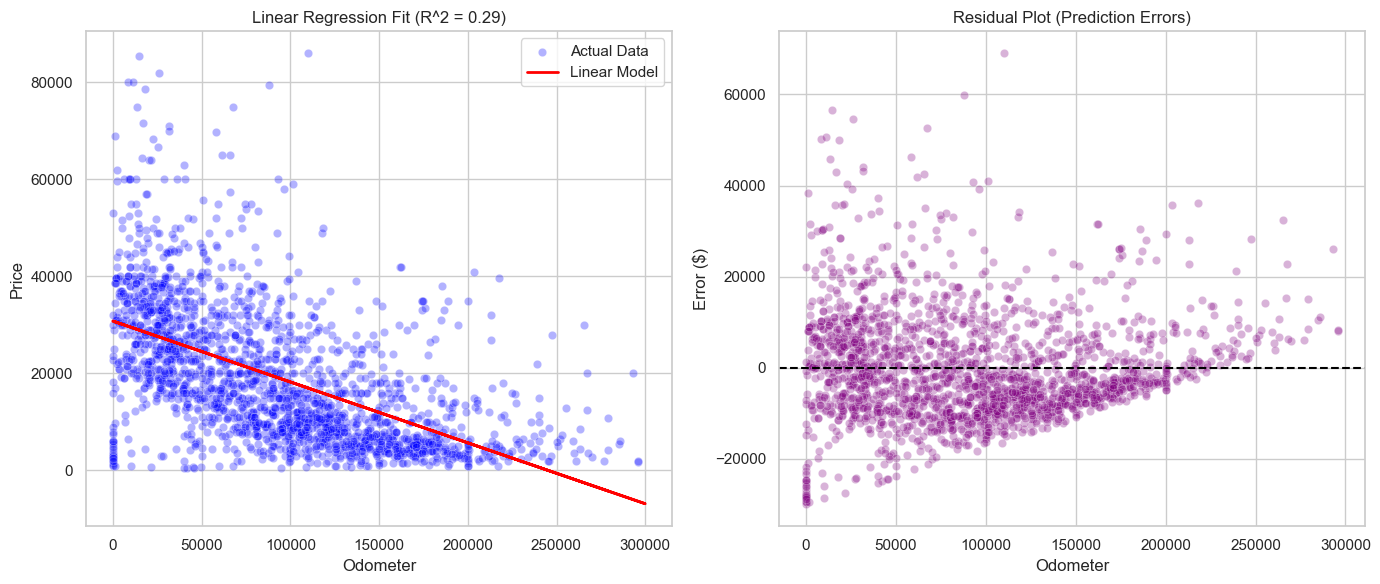

In [96]:
# Linear regression model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
# Added mean_absolute_error for L1 loss calculation
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

df_model = df_clean
df_model = df.dropna(subset=['odometer', 'price'])
# Filter outliers for a realistic mass-market model
df_model = df_model[(df_model['price'] > 500) & (df_model['price'] < 100000)]
df_model = df_model[(df_model['odometer'] > 0) & (df_model['odometer'] < 300000)]

# Select Feature (X) and Target (y)
X = df_model[['odometer']]  # Double brackets to keep it as a DataFrame (2D)
y = df_model['price']

# --- 3. Split Data (70:30) ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training Set Size: {len(X_train)}")
print(f"Testing Set Size: {len(X_test)}")

# --- 4. Fit Linear Regression Model ---
model = LinearRegression()
model.fit(X_train, y_train)

# --- 5. Evaluation (Calculating L1 and L2 Loss) ---
y_pred = model.predict(X_test)

# L1 Loss = Mean Absolute Error (MAE)
l1_loss = mean_absolute_error(y_test, y_pred)

# L2 Loss = Mean Squared Error (MSE)
l2_loss = mean_squared_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(l2_loss)

print("\n--- Model Loss Metrics ---")
print(f"L1 Loss (MAE): ${l1_loss:,.2f}")
print(f"L2 Loss (MSE): {l2_loss:,.2f}")
print(f"RMSE (Root Mean Squared Error): ${rmse:,.2f}")
print(f"R-Squared: {r2:.4f}")

plt.figure(figsize=(14, 6))

# Plot A: The Fit
plt.subplot(1, 2, 1)
subset = pd.concat([X_test, y_test], axis=1).sample(2000, random_state=42)
sns.scatterplot(x='odometer', y='price', data=subset, alpha=0.3, color='blue', label='Actual Data')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Linear Model')
plt.title(f'Linear Regression Fit (R^2 = {r2:.2f})')
plt.xlabel('Odometer')
plt.ylabel('Price')
plt.legend()
plt.savefig("images/Model-Fit.png")

# Plot B: Residuals
plt.subplot(1, 2, 2)
residuals = y_test - y_pred
subset_res = pd.DataFrame({'odometer': X_test['odometer'], 'residuals': residuals}).sample(2000, random_state=42)
sns.scatterplot(x='odometer', y='residuals', data=subset_res, alpha=0.3, color='purple')
plt.axhline(0, color='black', linestyle='--')
plt.title('Residual Plot (Prediction Errors)')
plt.xlabel('Odometer')
plt.ylabel('Error ($)')

plt.tight_layout()
plt.savefig("images/simple_regression_viz.png")

In [97]:
# Comparing Complexity, Variance

X = df_clean.loc[:,['odometer']]
y = df_clean['price']
sample = df_clean.sample(1000, random_state = 42)
X_train = sample.loc[:, ['odometer']]
y_train = sample['price']

model_predictions = {f'degree_{i}': None for i in range(1, 11)}
print("Starting Dictionary of Predictions\n", model_predictions)
for i in range(1, 50):
    pipe = Pipeline([('quad_features', PolynomialFeatures(degree = i, include_bias = False)), ('quad_model', LinearRegression())])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_train)
    model_predictions[f'degree_{i}'] = preds

model_predictions['degree_1'][:10]

pred_df = pd.DataFrame(model_predictions)
error_df = pred_df.subtract(y, axis = 0)
variance_errors = error_df.var()
highest_var_degree = int(variance_errors.idxmax().split('_')[1])
print(f"\nThe degree with the highest variance in errors is degree {highest_var_degree}.")
print(type(highest_var_degree))
print(highest_var_degree)


Starting Dictionary of Predictions
 {'degree_1': None, 'degree_2': None, 'degree_3': None, 'degree_4': None, 'degree_5': None, 'degree_6': None, 'degree_7': None, 'degree_8': None, 'degree_9': None, 'degree_10': None}

The degree with the highest variance in errors is degree 4.
<class 'int'>
4


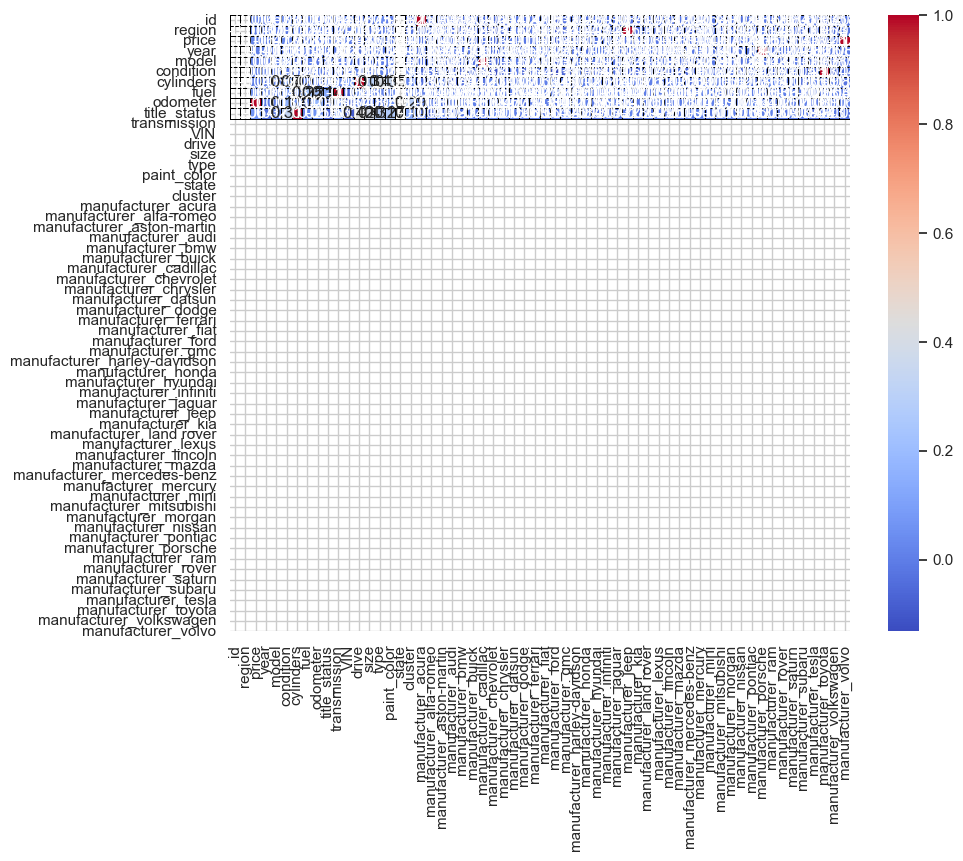

<Figure size 640x480 with 0 Axes>

In [102]:
# Applying one-hot encoding
df_encoded = pd.get_dummies(df, columns=['manufacturer'])
df_encoded = df_encoded.fillna(0)
df_encoded = df_encoded.astype(bool)
df_encoded.sample(10)

# Calculate the correlation matrix for the smaller DataFrame
corr = df_encoded.corr().sample(10)

# Generate the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr,annot=True, cmap='coolwarm', linewidths=0.5, linecolor='black',
            xticklabels=corr.columns, yticklabels=corr.columns)
plt.show()
plt.savefig("images/correlation_heatmap.png")


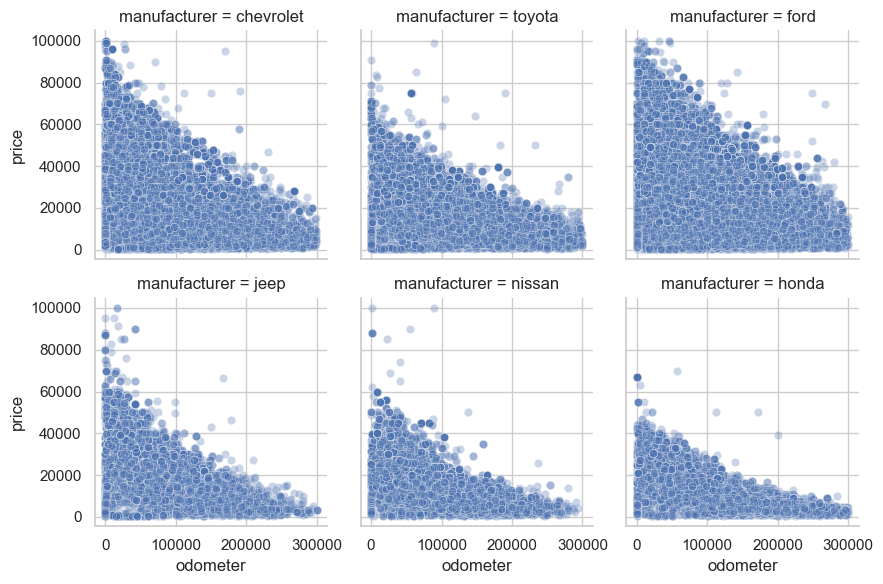

manufacturer       
chevrolet     price   -0.530340
ford          price   -0.470863
honda         price   -0.736177
jeep          price   -0.689777
nissan        price   -0.633117
toyota        price   -0.651089
Name: odometer, dtype: float64


<Figure size 640x480 with 0 Axes>

In [101]:
# Inference of Price of  Top 6 manufacturers by Odometer reading

import seaborn as sns
import matplotlib.pyplot as plt

top_brands = df_clean['manufacturer'].value_counts().head(6).index
df_top = df_clean[df_clean['manufacturer'].isin(top_brands)]

g = sns.FacetGrid(df_top, col="manufacturer", col_wrap=3)
g.map(sns.scatterplot, "odometer", "price", alpha=0.3)
plt.show()
plt.savefig("images/top_brands.png")

correlations = df_top.groupby('manufacturer')[['price', 'odometer']].corr().iloc[0::2, -1]
print(correlations)

Inference
1. Strong correlationship for brands like Honda, Jeep, Toyota, Nissan as correlation are >-0.63
2. Weak correlationship for brands like Ford, Chevrolet. Other features like model, color etc could influence

In [43]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df_model = df_clean[['year', 'manufacturer', 'odometer', 'price']].copy()
df_model.dropna(inplace=True)
df_model = df_model[(df_model['price'] > 500) & (df_model['price'] < 100000)]
df_model = df_model[(df_model['odometer'] > 0) & (df_model['odometer'] < 300000)]

print(f"Data shape after cleaning: {df_model.shape}")

X = df_model[['year', 'manufacturer', 'odometer']]
y = df_model['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_features = ['manufacturer']
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

numerical_features = ['year', 'odometer']
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

print("Training Linear Regression model...")
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n--- Model Performance ---")
print(f"Mean Absolute Error (MAE): ${mae:,.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:,.2f}")
print(f"R^2 Score: {r2:.4f}")

feature_names = (model.named_steps['preprocessor']
                 .transformers_[1][1]
                 .get_feature_names_out(categorical_features))

coeffs = model.named_steps['regressor'].coef_

print("\n--- Key Influencers ---")
print(f"Year Coefficient (Standardized): {coeffs[0]:.2f}")
print(f"Odometer Coefficient (Standardized): {coeffs[1]:.2f}")

mfg_coeffs = pd.Series(coeffs[2:], index=feature_names).sort_values(ascending=False)

print("\nTop 5 Manufacturers that INCREASE Price (Linear assumption):")
print(mfg_coeffs.head(5))

print("\nTop 5 Manufacturers that DECREASE Price (Linear assumption):")
print(mfg_coeffs.tail(5))

Data shape after cleaning: (362873, 4)
Training Linear Regression model...

--- Model Performance ---
Mean Absolute Error (MAE): $7,402.73
Root Mean Squared Error (RMSE): $10,365.97
R^2 Score: 0.4662

--- Key Influencers ---
Year Coefficient (Standardized): 3283.43
Odometer Coefficient (Standardized): -6877.08

Top 5 Manufacturers that INCREASE Price (Linear assumption):
manufacturer_ferrari         51706.561038
manufacturer_aston-martin    21800.976687
manufacturer_tesla           11655.329883
manufacturer_porsche         10588.253913
manufacturer_ram             10201.377912
dtype: float64

Top 5 Manufacturers that DECREASE Price (Linear assumption):
manufacturer_harley-davidson    -8017.691773
manufacturer_saturn             -8983.283823
manufacturer_hyundai            -9270.160557
manufacturer_kia                -9629.912430
manufacturer_fiat              -12533.441992
dtype: float64


### CRISP:DM - Phase 6 :  Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

### Basic Models (1 & 2), Linear Model and Feature (Fuel and Drive Type)

In [44]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

df_clean = df[(df['price'] > 1000) & (df['price'] < 100000)]
df_clean = df_clean[(df_clean['year'] >= 1995) & (df_clean['year'] <= 2022)]
df_clean = df_clean[(df_clean['odometer'] > 1000) & (df_clean['odometer'] < 250000)]
df_clean = df_clean.dropna(subset=['year', 'odometer', 'fuel', 'drive'])

# Simple Model 1: Age and Mileage impact (Linear relationship between Age of car and Mileage)
X_simple = df_clean[['year', 'odometer']]
y = df_clean['price']
model_simple = LinearRegression()
model_simple.fit(X_simple, y)

print(" ==> Linear relationship between Age of car and Mileage <==")
print(f"Base Intercept: ${model_simple.intercept_:,.2f}")
print(f"Value per Year Newer: ${model_simple.coef_[0]:,.2f}")
print(f"Value per Mile Driven: ${model_simple.coef_[1]:,.4f}")

# Model 2: Features Impact (Fuel, Drive)  (Features impacting price)
# We want to see the premium for Diesel vs Gas, and 4wd vs fwd
df_features = df_clean[['price', 'fuel', 'drive']].copy()
# Create simplistic dummies for rough estimates
df_features['is_diesel'] = (df_features['fuel'] == 'diesel').astype(int)
df_features['is_4wd'] = (df_features['drive'] == '4wd').astype(int)

X_feat = df_features[['is_diesel', 'is_4wd']]
y_feat = df_features['price']
model_feat = LinearRegression()
model_feat.fit(X_feat, y_feat)

print("\n ==>Rough estimate / impact due to Fuel and Drive type <== ")
print(f"Diesel Premium: ${model_feat.coef_[0]:,.2f}")
print(f"4WD Premium: ${model_feat.coef_[1]:,.2f}")

 ==> Linear relationship between Age of car and Mileage <==
Base Intercept: $-2,018,274.83
Value per Year Newer: $1,016.18
Value per Mile Driven: $-0.0750

 ==>Rough estimate / impact due to Fuel and Drive type <== 
Diesel Premium: $16,406.89
4WD Premium: $7,196.47


Data  for plotting: 236911 records


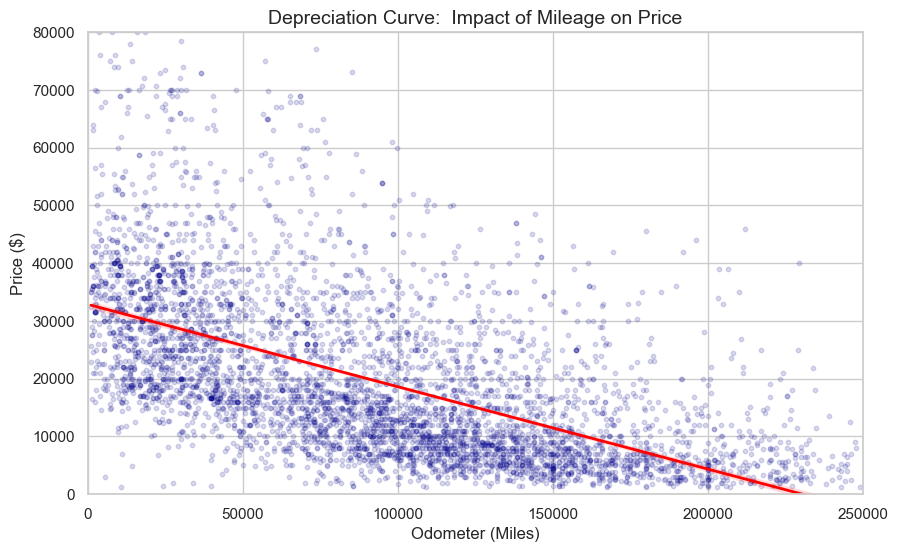

Image saved.png
Image saved.png


<Figure size 640x480 with 0 Axes>

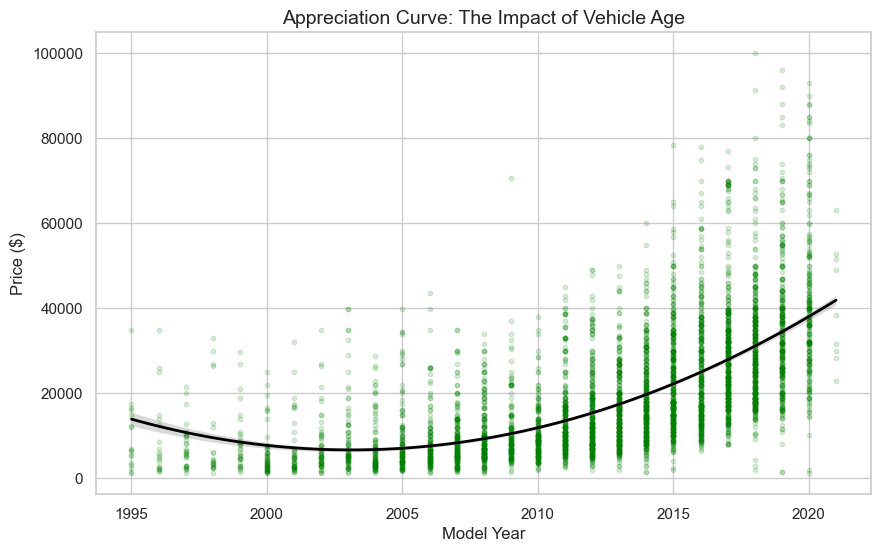

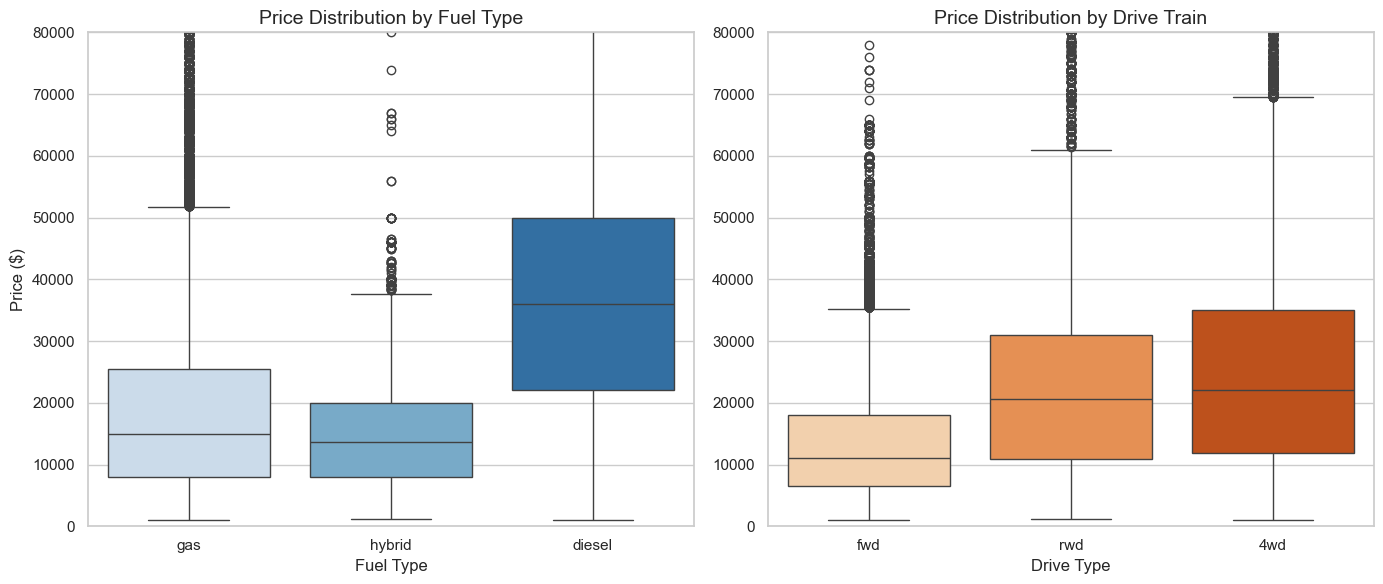

Image saved.png


<Figure size 640x480 with 0 Axes>

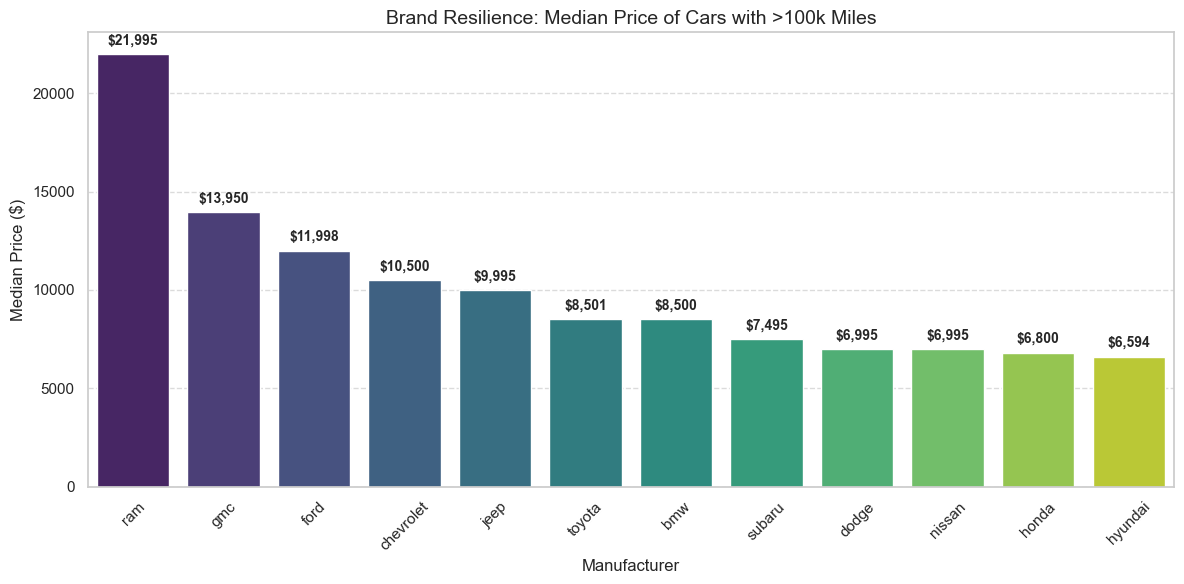

Image saved.png


<Figure size 640x480 with 0 Axes>

In [105]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df_clean = df.dropna(subset=['year', 'odometer', 'manufacturer', 'fuel', 'drive', 'price'])
df_clean = df_clean[
    (df_clean['price'] > 1000) & (df_clean['price'] < 100000) &
    (df_clean['year'] >= 1995) & (df_clean['year'] <= 2022) &
    (df_clean['odometer'] > 1000) & (df_clean['odometer'] < 250000)
]

print(f"Data  for plotting: {len(df_clean)} records")
sns.set_theme(style="whitegrid")

# Item 1: Visualization 1: The Depreciation Curve (Price vs Odometer)
plt.figure(figsize=(10, 6))
subset = df_clean.sample(5000, random_state=42)   #  Limited to 5000 points to keep the scatterplot effective
sns.regplot(
    data=subset,
    x='odometer',
    y='price',
    scatter_kws={'alpha': 0.15, 's': 10, 'color': 'darkblue'},
    line_kws={'color': 'red', 'linewidth': 2}
)
plt.title('Depreciation Curve:  Impact of Mileage on Price', fontsize=14)
plt.xlabel('Odometer (Miles)', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.xlim(0, 250000)
plt.ylim(0, 80000)
plt.show()
plt.savefig("images/Image - DepreciationCurve-Price-Odo.png")
print("Image saved.png")


# Item 2: Visualization 2: The Age Premium (Price vs Year)
plt.figure(figsize=(10, 6))
sns.regplot(
    data=subset,
    x='year',
    y='price',
    scatter_kws={'alpha': 0.15, 's': 10, 'color': 'green'},
    line_kws={'color': 'black', 'linewidth': 2},
    order=2 # Using a polynomial fit (order 2) because car prices curve upward for new cars
)
plt.title('Appreciation Curve: The Impact of Vehicle Age', fontsize=14)
plt.xlabel('Model Year', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.show
plt.savefig("images/Image - Age Premium - Price vs Year.png")
print("Image saved.png")

# Item 3: Visualization 3: Feature Premiums (Fuel & Drive)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))


fuel_subset = df_clean[df_clean['fuel'].isin(['gas', 'diesel', 'hybrid'])]
sns.boxplot(data=fuel_subset, x='fuel', y='price', ax=axes[0], palette='Blues', order=['gas', 'hybrid', 'diesel'])
axes[0].set_title('Price Distribution by Fuel Type', fontsize=14)
axes[0].set_ylim(0, 80000)
axes[0].set_ylabel('Price ($)')
axes[0].set_xlabel('Fuel Type')

sns.boxplot(data=df_clean, x='drive', y='price', ax=axes[1], palette='Oranges', order=['fwd', 'rwd', '4wd'])
axes[1].set_title('Price Distribution by Drive Train', fontsize=14)
axes[1].set_ylim(0, 80000)
axes[1].set_ylabel('') # remove y label for cleaner look
axes[1].set_xlabel('Drive Type')
plt.tight_layout()
plt.show()
plt.savefig("images/Image - Fuel and Drive.png")
print("Image saved.png")


# Item 4: Visualization 4: Brand Resilience (>100k Miles)

high_mileage = df_clean[df_clean['odometer'] > 100000]
top_mfg = high_mileage['manufacturer'].value_counts().head(12).index              # Top 12 manufacturers by volume in this high-mileage segment
high_mileage_subset = high_mileage[high_mileage['manufacturer'].isin(top_mfg)]

order = high_mileage_subset.groupby('manufacturer')['price'].median().sort_values(ascending=False).index   # Calculate median price for sorting

plt.figure(figsize=(12, 6))
sns.barplot(
    data=high_mileage_subset,
    x='manufacturer',
    y='price',
    order=order,
    palette='viridis',
    estimator=np.median, # Use median to be robust against outliers
    errorbar=None
)
plt.title('Brand Resilience: Median Price of Cars with >100k Miles', fontsize=14)
plt.ylabel('Median Price ($)', fontsize=12)
plt.xlabel('Manufacturer', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
ax = plt.gca()
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 500,
            f'${height:,.0f}',
            ha="center", fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()
plt.savefig("images/Image - Median price over 100K miles.png")
print("Image saved.png")


### Additional Scatter Plots for Price variation with Paint Colors and Luxury Car segment

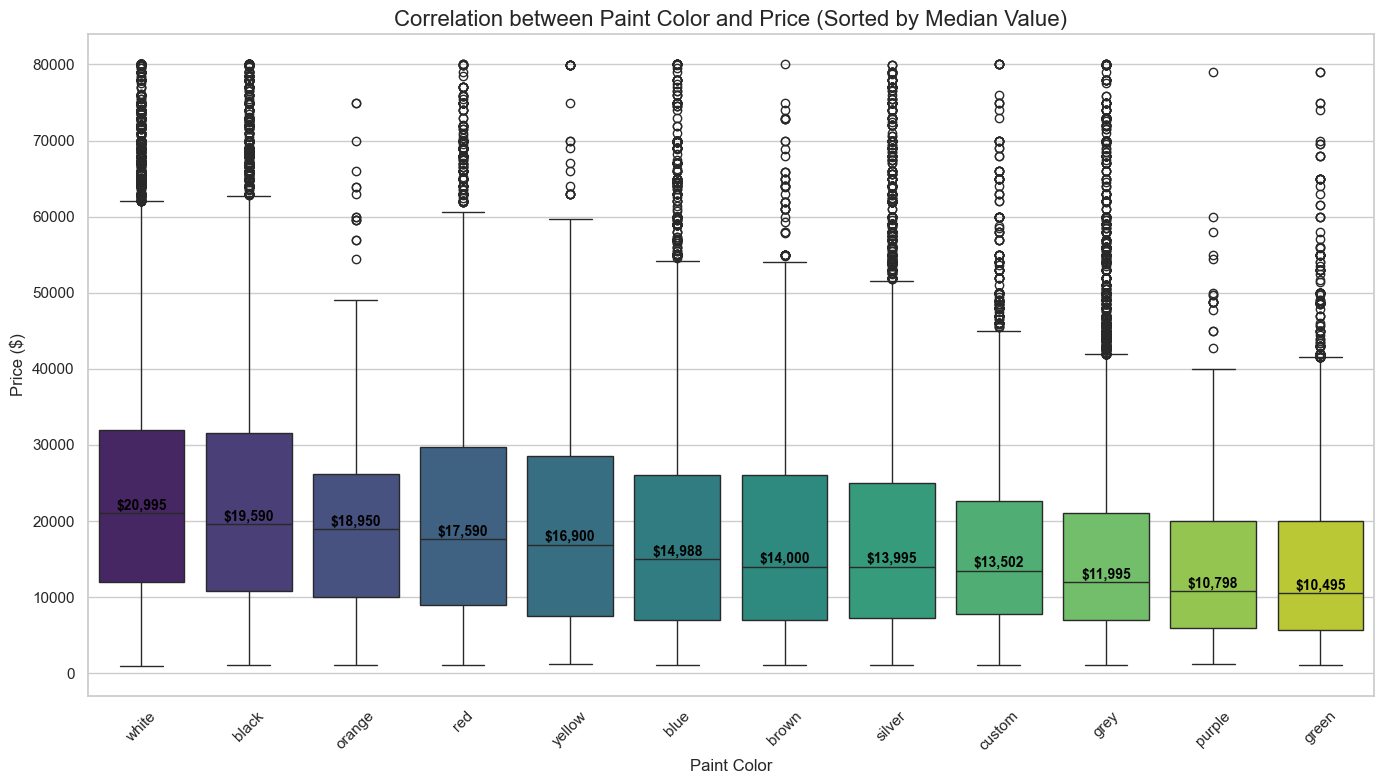

Image-saved.png'


<Figure size 640x480 with 0 Axes>

In [106]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_clean = df.dropna(subset=['paint_color', 'price'])
df_clean = df_clean[(df_clean['price'] > 1000) & (df_clean['price'] < 80000)]
df_clean = df_clean[(df_clean['year'] > 2000)] # Focus on modern era for relevant color trends

top_colors = df_clean['paint_color'].value_counts().head(12).index  # Filter to keep only common colors (top 20)
df_clean = df_clean[df_clean['paint_color'].isin(top_colors)]

# Calculate the median price for each color to sort the chart nicely
order = df_clean.groupby('paint_color')['price'].median().sort_values(ascending=False).index

plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid")

# This shows the median (line), the 25th-75th percentiles (box), and outliers (dots)
chart = sns.boxplot(
    data=df_clean,
    x='paint_color',
    y='price',
    order=order,
    palette='viridis'
)

plt.title('Correlation between Paint Color and Price (Sorted by Median Value)', fontsize=16)
plt.xlabel('Paint Color', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.xticks(rotation=45)

# Add median labels on top of the boxes for clarity
for i, color in enumerate(order):
    median_val = df_clean[df_clean['paint_color'] == color]['price'].median()
    plt.text(i, median_val + 500, f'${median_val:,.0f}', ha='center', color='black', weight='bold', fontsize=10)

plt.tight_layout()
plt.show()
plt.savefig("images/color_price_chart.png")
print("Image-saved.png'")

Top 5 Luxury Brands identified: ['ferrari', 'aston-martin', 'tesla', 'porsche', 'ram']
    manufacturer          price     id
11       ferrari  124223.986111     72
2   aston-martin   75063.588235     17
38         tesla   41196.182609    805
33       porsche   36435.212858   1151
34           ram   34610.280449  12020

--- Correlation with Price (Luxury Segment Only) ---
Ferrari: Odometer Corr = -0.27 | Age Corr = 0.67
Aston-martin: Odometer Corr = -0.40 | Age Corr = 0.80
Tesla: Odometer Corr = -0.38 | Age Corr = 0.30
Porsche: Odometer Corr = -0.56 | Age Corr = 0.23
Ram: Odometer Corr = -0.43 | Age Corr = 0.49


<Figure size 1200x700 with 0 Axes>

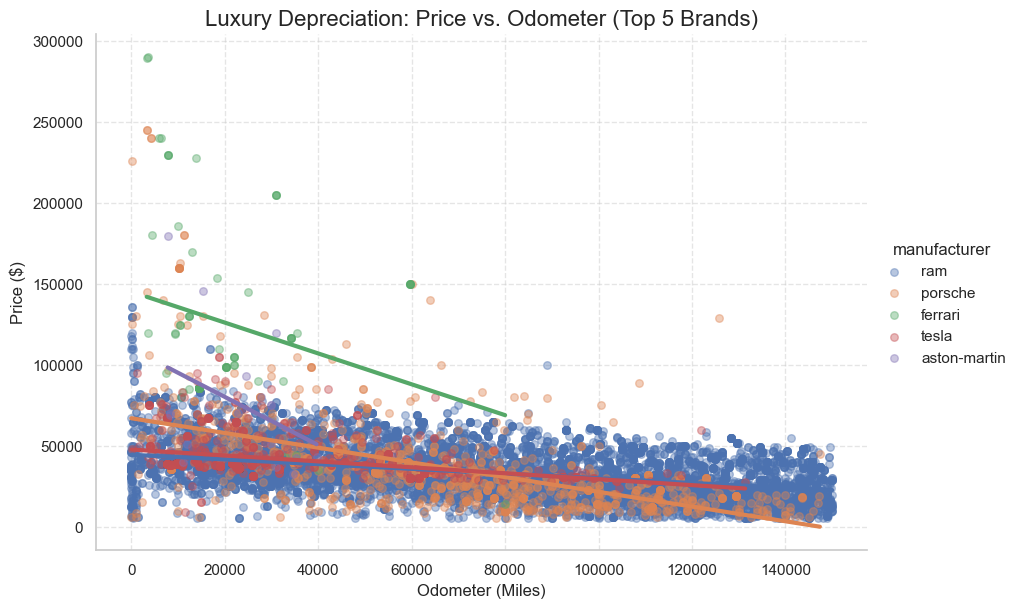

<Figure size 640x480 with 0 Axes>

In [108]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df_clean = df.dropna(subset=['manufacturer', 'price', 'year', 'odometer'])
df_clean = df_clean[(df_clean['price'] > 5000) & (df_clean['price'] < 300000)]
df_clean = df_clean[(df_clean['odometer'] > 0) & (df_clean['odometer'] < 150000)]

# --- 2. Identify Top 5 Luxury Brands ---
# We require at least 15 sales to count as a "brand" (excludes one-offs like 'Morgan' with 3 sales)
brand_stats = df_clean.groupby('manufacturer').agg({
    'price': 'mean',
    'id': 'count'
}).reset_index()

# Filter for volume > 15 and sort by Average Price
luxury_brands = brand_stats[brand_stats['id'] >= 15].sort_values(by='price', ascending=False).head(5)
top_5_names = luxury_brands['manufacturer'].tolist()

print(f"Top 5 Luxury Brands identified: {top_5_names}")
print(luxury_brands)

# Filter dataset to ONLY these 5 brands
df_luxury = df_clean[df_clean['manufacturer'].isin(top_5_names)].copy()

# --- 3. Feature Analysis (Correlation) ---
print("\n--- Correlation with Price (Luxury Segment Only) ---")
for brand in top_5_names:
    subset = df_luxury[df_luxury['manufacturer'] == brand]
    # Odometer Impact
    odo_corr = subset['price'].corr(subset['odometer'])
    # Age Impact
    age_corr = subset['price'].corr(subset['year'])

    print(f"{brand.capitalize()}: Odometer Corr = {odo_corr:.2f} | Age Corr = {age_corr:.2f}")

# --- 4. Visualization: The Luxury Depreciation Curve ---
plt.figure(figsize=(12, 7))
sns.set_theme(style="whitegrid")

# Create a scatterplot with regression lines for each brand
# This shows how FAST each brand loses value
sns.lmplot(
    data=df_luxury,
    x='odometer',
    y='price',
    hue='manufacturer',
    height=6,
    aspect=1.5,
    ci=None, # Remove confidence intervals for cleaner lines
    scatter_kws={'alpha': 0.4, 's': 30},
    line_kws={'linewidth': 3}
)

plt.title('Luxury Depreciation: Price vs. Odometer (Top 5 Brands)', fontsize=16)
plt.xlabel('Odometer (Miles)', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
plt.savefig("images/luxury_depreciation.png")


### End of Notebook